# Tests de l'algorithme de Thorisson 

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt

def thorisson_coupling(p_densite, p_echantillon, q_densite, q_echantillon, C=1.0):
    X = p_echantillon()
    U = np.random.uniform()
    
    p_dens = p_densite(X)
    q_dens = q_densite(X)
    
    if U < min(q_dens / p_dens, C):
        Y = X
    else:
        A = 0
        while A != 1:
            Z = q_echantillon()
            U = np.random.uniform()
            p_dens_Z = p_densite(Z)
            q_dens_Z = q_densite(Z)
            if U > min(1, C * p_dens_Z / q_dens_Z):
                A = 1
        Y = Z
    return X, Y

def calcul_integral_min(p_densite, q_densite, C=1.0, limit_integrale=5, num_points=100000):
    x_vals = np.linspace(-limit_integrale, limit_integrale, num_points)
    min_vals = np.minimum(C * p_densite(x_vals), q_densite(x_vals))
    dx = x_vals[1] - x_vals[0]
    integral = np.sum(min_vals) * dx
    return integral

def erreur_egalite(X_val, Y_val, e=0.01):
    return np.sum(np.absolute(X_val - Y_val) <= e)

## III. Lois normale N(0,1) et uniforme U[-1,1]

In [14]:
def p_densite(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # Densité normale

def q_densite(x):
    return np.where(np.absolute(x) <= 1 , 1/2, 0) # Densité uniforme sur [-1, 1]

# Fonction d'échantillonnage pour la densité p et q
def p_echantillon():
    return np.random.normal()

def q_echantillon():
    return np.random.uniform(-1, 1)

### III.1. Choix du paramètre C

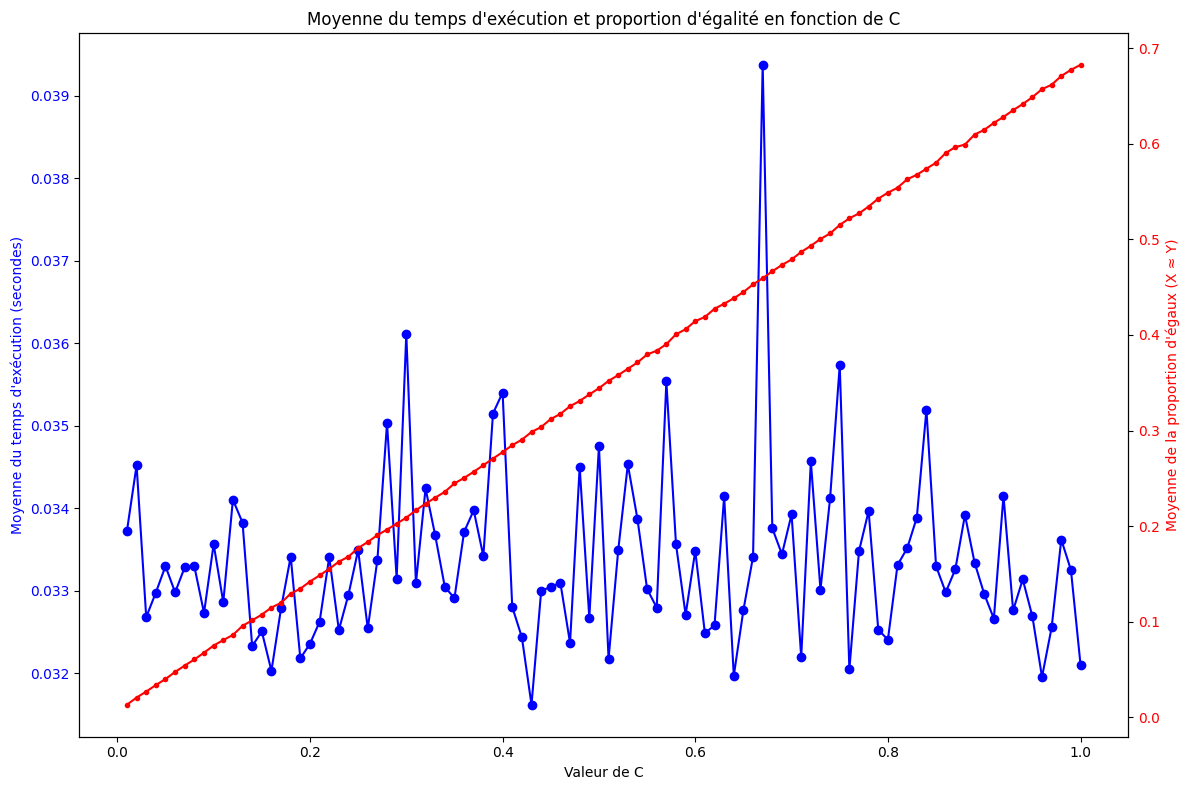

La meilleure valeur de C est : 1.00
Moyenne de la proportion d'égalité à C=1.00: 0.6825
Moyenne du temps d'exécution à C=1.00: 0.0321 secondes


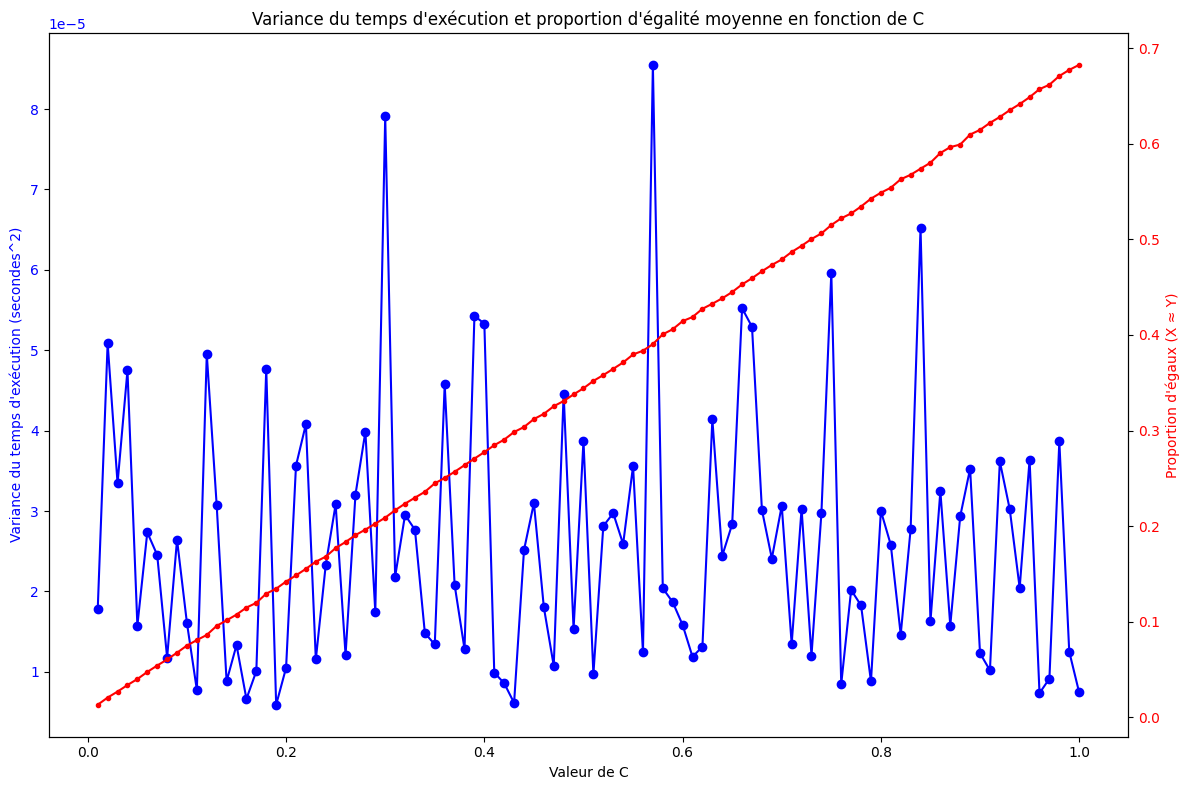

La meilleure valeur de C est : 1.00
Proportion d'égalité moyenne à C=1.00: 0.6825
Variance du temps d'exécution à C=1.00: 0.000007 secondes^2


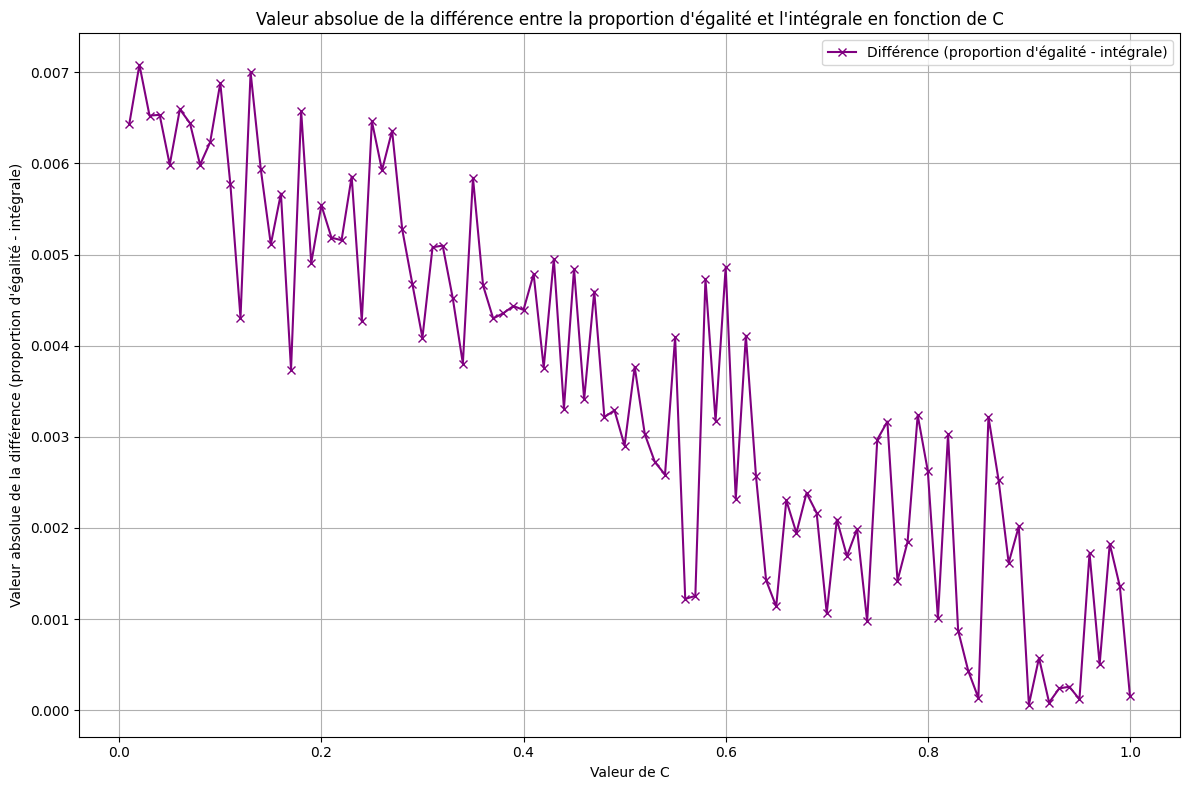

La meilleure valeur de C est : 0.90
Différence (proportion d'égalité - intégrale) à C=0.90: 0.0001


In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour faire varier C et mesurer la moyenne du temps d'exécution, ainsi que la moyenne de la proportion d'égalité
def test_variation_C_with_avg_metrics(C_values, num_tests=1000, num_trials=1000):
    results = []

    for C in C_values:
        all_X_vals, all_Y_vals = [], []
        execution_times = []
        proportions_per_trial = []

        # Effectuer plusieurs essais pour mesurer la moyenne du temps d'exécution et calculer la proportion moyenne
        for _ in range(num_trials):
            X_vals, Y_vals = [], []
            start_time = time.time()
            
            # Simuler les paires X et Y pour num_tests échantillons
            for _ in range(num_tests):
                X, Y = thorisson_coupling(p_densite, p_echantillon, q_densite, q_echantillon, C)
                X_vals.append(X)
                Y_vals.append(Y)

            end_time = time.time()
            execution_times.append(end_time - start_time)
            
            # Calculer la proportion d'égalité pour cet essai
            e = 0.01
            erreur = erreur_egalite(np.array(X_vals), np.array(Y_vals), e)
            proportion_egales = erreur / num_tests
            proportions_per_trial.append(proportion_egales)
        
            all_X_vals.extend(X_vals)
            all_Y_vals.extend(Y_vals)
        
        # Calculer la moyenne du temps d'exécution
        avg_execution_time = np.mean(execution_times)

        # Calculer la variance des temps d'exécution
        variance_execution_time = np.var(execution_times)
        
        # Calculer la moyenne des proportions d'égalité sur tous les essais
        avg_proportion_egales = np.mean(proportions_per_trial)
        
        # Stocker les résultats
        results.append((C, avg_proportion_egales, avg_execution_time, variance_execution_time))

    return results

# Générer une liste de C plus dense
C_values_dense = np.arange(0.01, 1.01, 0.01)  # Valeurs de C de 0.01 à 1.0 avec un pas de 0.01

# Effectuer les tests
results_dense = test_variation_C_with_avg_metrics(C_values_dense, num_tests=1000, num_trials=200)

# Préparer les données pour le graphique
C_vals, avg_proportion_egales, avg_execution_times, variance_execution_time = zip(*results_dense)

# Création du graphique avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 8))

# Axe principal pour la moyenne du temps d'exécution
ax1.set_xlabel('Valeur de C')
ax1.set_ylabel('Moyenne du temps d\'exécution (secondes)', color='b')
ax1.plot(C_vals, avg_execution_times, marker='o', linestyle='-', color='b', label='Moyenne du temps d\'exécution')
ax1.tick_params(axis='y', labelcolor='b')

# Création du second axe Y pour la proportion d'égalité moyenne
ax2 = ax1.twinx()  # Crée un axe secondaire qui partage le même axe X
ax2.set_ylabel('Moyenne de la proportion d\'égaux (X ≈ Y)', color='r')
ax2.plot(C_vals, avg_proportion_egales, marker='.', linestyle='-', color='r', label='Moyenne de la proportion d\'égalité')
ax2.tick_params(axis='y', labelcolor='r')

# Ajouter un titre et une légende
plt.title('Moyenne du temps d\'exécution et proportion d\'égalité en fonction de C')

# Afficher le graphique
fig.tight_layout()  # Ajuster les éléments pour éviter le chevauchement
plt.show()

# Trouver la meilleure valeur de C (la plus haute proportion d'égalité avec un faible temps d'exécution moyen)
best_C_index = np.argmax(avg_proportion_egales)
best_C = C_vals[best_C_index]
best_proportion = avg_proportion_egales[best_C_index]
best_avg_execution_time = avg_execution_times[best_C_index]

print(f"La meilleure valeur de C est : {best_C:.2f}")
print(f"Moyenne de la proportion d'égalité à C={best_C:.2f}: {best_proportion:.4f}")
print(f"Moyenne du temps d'exécution à C={best_C:.2f}: {best_avg_execution_time:.4f} secondes")

# Création du graphique avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 8))

# Axe principal pour la variance du temps d'exécution
ax1.set_xlabel('Valeur de C')
ax1.set_ylabel('Variance du temps d\'exécution (secondes^2)', color='b')
ax1.plot(C_vals, variance_execution_time, marker='o', linestyle='-', color='b', label='Variance du temps d\'exécution')
ax1.tick_params(axis='y', labelcolor='b')

# Création du second axe Y pour la proportion d'égalité moyenne
ax2 = ax1.twinx()  # Crée un axe secondaire qui partage le même axe X
ax2.set_ylabel('Proportion d\'égaux (X ≈ Y)', color='r')
ax2.plot(C_vals, avg_proportion_egales, marker='.', linestyle='-', color='r', label='Proportion d\'égalité moyenne')
ax2.tick_params(axis='y', labelcolor='r')

# Ajouter un titre et une légende
plt.title('Variance du temps d\'exécution et proportion d\'égalité moyenne en fonction de C')

# Afficher le graphique
fig.tight_layout()  # Ajuster les éléments pour éviter le chevauchement
plt.show()

# Trouver la meilleure valeur de C (la plus haute proportion d'égalité avec une faible variance)
best_C_index = np.argmax(avg_proportion_egales)
best_C = C_vals[best_C_index]
best_proportion = avg_proportion_egales[best_C_index]
best_variance = variance_execution_time[best_C_index]

print(f"La meilleure valeur de C est : {best_C:.2f}")
print(f"Proportion d'égalité moyenne à C={best_C:.2f}: {best_proportion:.4f}")
print(f"Variance du temps d'exécution à C={best_C:.2f}: {best_variance:.6f} secondes^2")

# Calculer l'intégrale min(C*p(x), q(x)) pour chaque valeur de C
integral_min_vals = [calcul_integral_min(p_densite, q_densite, C) for C in C_vals]

# Calculer la valeur absolue de la différence entre la proportion d'égalité moyenne et l'intégrale
difference_vals = np.abs(np.array(avg_proportion_egales) - np.array(integral_min_vals))

# Création du graphique avec la valeur absolue de la différence
plt.figure(figsize=(12, 8))

# Tracer la valeur absolue de la différence entre la proportion d'égalité et l'intégrale
plt.plot(C_vals, difference_vals, marker='x', linestyle='-', color='purple', label='Différence (proportion d\'égalité - intégrale)')

# Ajouter un titre et des labels
plt.title('Valeur absolue de la différence entre la proportion d\'égalité et l\'intégrale en fonction de C')
plt.xlabel('Valeur de C')
plt.ylabel('Valeur absolue de la différence (proportion d\'égalité - intégrale)')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.tight_layout()
plt.show()

# Trouver la meilleure valeur de C (la plus petite différence entre la proportion d'égalité et l'intégrale)
best_C_index = np.argmin(difference_vals)
best_C = C_vals[best_C_index]
best_difference = difference_vals[best_C_index]

print(f"La meilleure valeur de C est : {best_C:.2f}")
print(f"Différence (proportion d'égalité - intégrale) à C={best_C:.2f}: {best_difference:.4f}")

On choisit par la suite comme paramètre **C = 1** puisqu'il semble maximiser la proportion d'égalité tout en gardant un temps d'exécution moyen et une variance de ce temps d'exécution réduit. De plus, la valeur absolue de la différence entre l'intégrale et la proportion d'égalité moyenne pour ce choix de paramètre est relativement faible.

In [16]:
# Paramètre C
C = 1

# Génération de couples de variables X, Y
X_vals = []
Y_vals = []
times   = []
for _ in range(100000):
    debut=time.time()
    x, y = thorisson_coupling(p_densite, p_echantillon, q_densite, q_echantillon, C)
    fin=time.time()
    X_vals.append(x)
    Y_vals.append(y)
    times.append(fin-debut)
X_vals = np.array(X_vals)
Y_vals = np.array(Y_vals)
times   = np.array(times)

### III.2. Test de Convergence des Échantillons

Probabilité d'égalité P(X = Y) = 0.680
Valeur théorique (∫ min(C*p,q)) ≈ 0.683


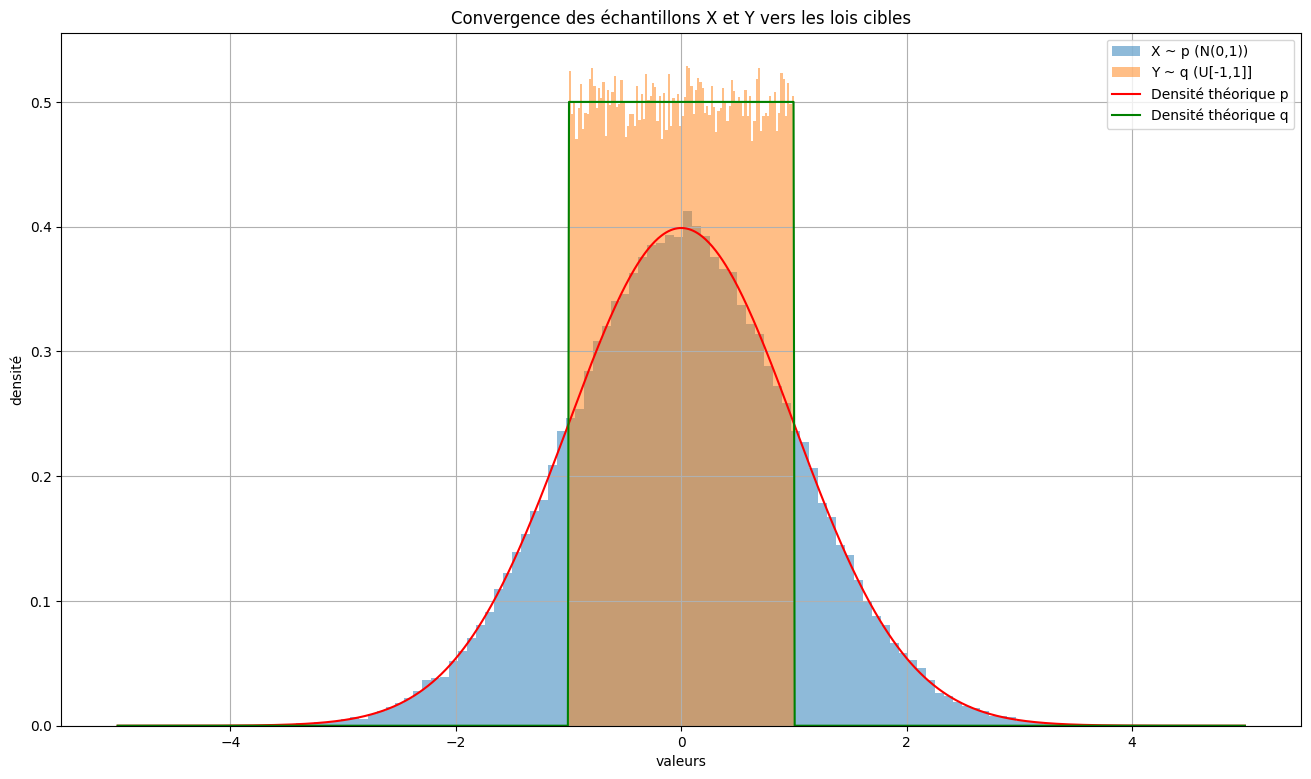

Ainsi, on peut affirmer que les variables X et Y suivent respectivement les lois p et q.
De plus leur probabilité d'égalité est très proche de l'intégrale du minimum des densités.
L'algorithme de Thorisson modifié fonctionne.


In [17]:
# Visualisation de la convergence des échantillons
plt.figure(figsize=(16, 9))
plt.hist(X_vals, bins=100, density=True, alpha=0.5, label='X ~ p (N(0,1))') #Le paramètre alpha joue sur la transparence de l'histogramme pour visualiser les zones de recouvrement
plt.hist(Y_vals, bins=100, density=True, alpha=0.5, label='Y ~ q (U[-1,1]]') #Le paramètre density permet de vérifier les lois marginales de X et de Y

# Analyse : probabilité d'égalité
print(f"Probabilité d'égalité P(X = Y) = {erreur_egalite(X_vals,Y_vals) / len(X_vals):.3f}")

# Analyse : valeur théorique de l'intrégrale du min
print(f"Valeur théorique (∫ min(C*p,q)) ≈ {calcul_integral_min(p_densite, q_densite, C=C):.3f}")

# Densités théoriques
x_vals = np.linspace(-5, 5, 1000)
plt.plot(x_vals, p_densite(x_vals), 'r-', label='Densité théorique p')
plt.plot(x_vals, q_densite(x_vals), 'g-', label='Densité théorique q')

plt.legend()
plt.title("Convergence des échantillons X et Y vers les lois cibles")
plt.xlabel("valeurs")
plt.ylabel("densité")
plt.grid(True)
plt.show()

print("Ainsi, on peut affirmer que les variables X et Y suivent respectivement les lois p et q.")
print("De plus leur probabilité d\'égalité est très proche de l'intégrale du minimum des densités.")
print("L\'algorithme de Thorisson modifié fonctionne.")

### III.3. Test de l'Autocorrélation

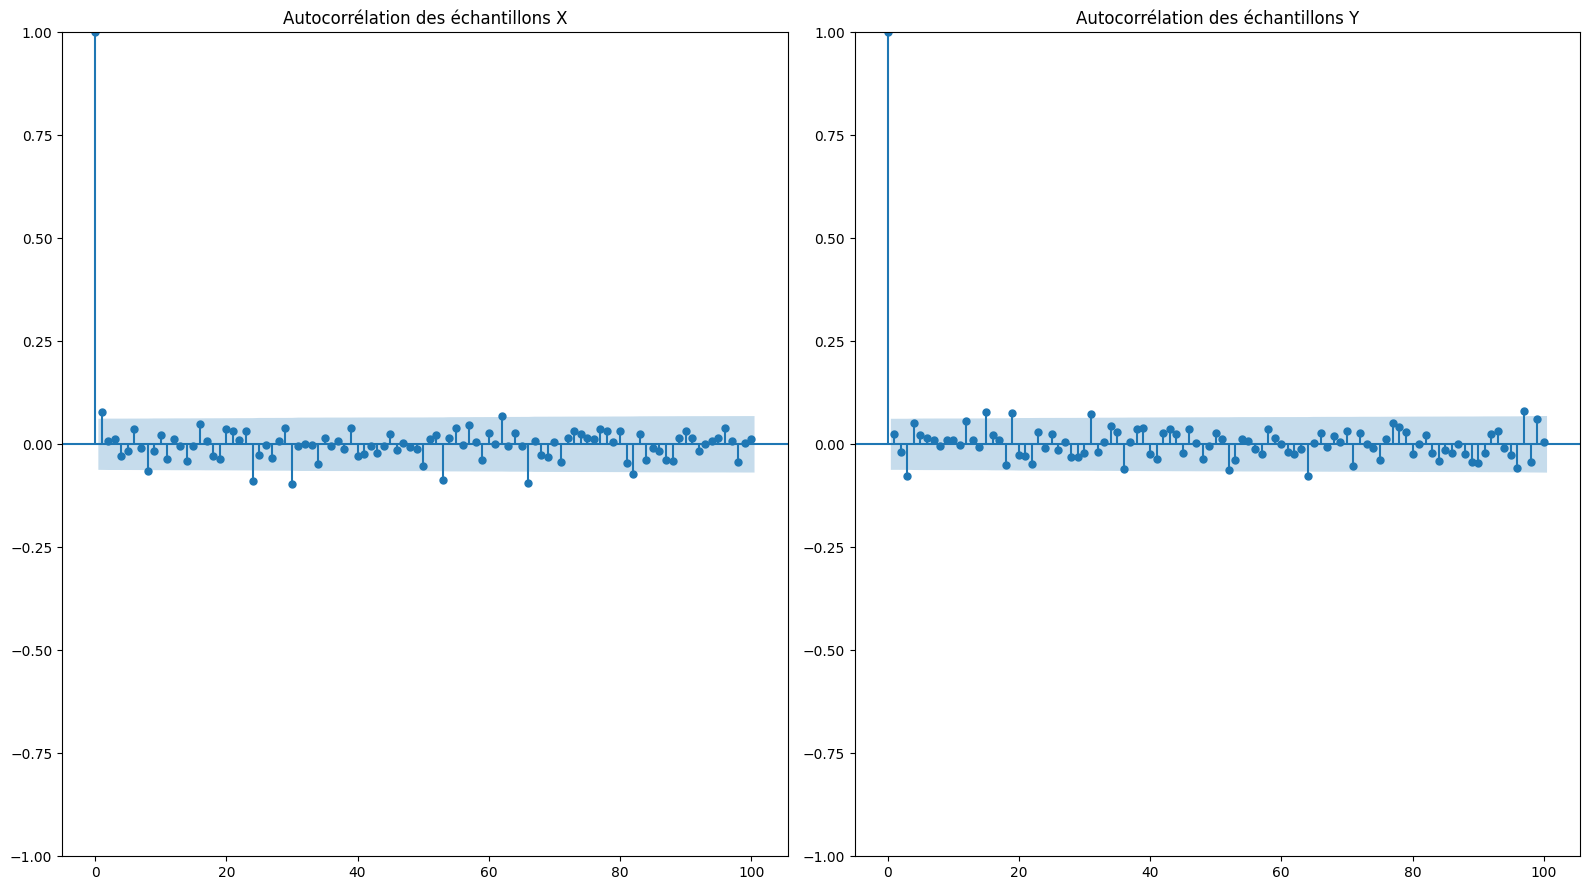

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

# Supposons que X_vals et Y_vals sont déjà générés
# Limiter la taille des échantillons pour éviter des problèmes de performance
sample_size = 1000  # Choisir un sous-ensemble de 1000 valeurs pour l'analyse

# Si X_vals et Y_vals ont plus de 1000 éléments, on les réduit
X_vals_subsample = np.random.choice(X_vals, size=sample_size, replace=False)
Y_vals_subsample = np.random.choice(Y_vals, size=sample_size, replace=False)

# Autocorrélation pour X et Y
plt.figure(figsize=(16, 9))

# Première figure pour X_vals
plt.subplot(1, 2, 1)
plot_acf(X_vals_subsample, lags=100, ax=plt.gca())
plt.title("Autocorrélation des échantillons X")

# Deuxième figure pour Y_vals
plt.subplot(1, 2, 2)
plot_acf(Y_vals_subsample, lags=100, ax=plt.gca())
plt.title("Autocorrélation des échantillons Y")

plt.tight_layout()
plt.show()

Comme l'autocorrélation dépasse légèrement ±0.05 seulement pour quelques valeurs de lag (en dehors de 0), et que cette déviation n'est pas persistante sur plusieurs lags, il est raisonnable de conclure qu'il s'agit probablement d'un bruit statistique ou d'une fluctuation naturelle dans l'estimation. Puisque cette déviation semble aléatoire et se situe dans une plage raisonnable, **on peut considérer les échantillons comme étant globalement indépendants.**

### III.4. Analyse de la Performance

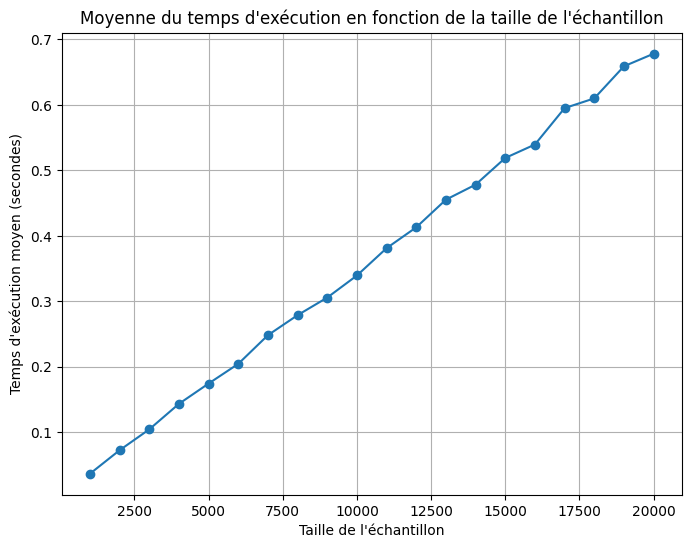

In [11]:
# Plage des tailles d'échantillons
sample_sizes = np.arange(1000, 21000, 1000)
num_repeats = 20  # Nombre de répétitions pour chaque taille d'échantillon
times_per_size = []

# Mesure du temps pour chaque taille d'échantillon
for size in sample_sizes:
    repeat_times = []  # Liste pour stocker les temps d'exécution de chaque répétition
    for _ in range(num_repeats):
        X_vals = []
        Y_vals = []
        start_time = time.time()
        
        # Exécution de l'algorithme pour la taille d'échantillon donnée
        for _ in range(size):
            x, y = thorisson_coupling(p_densite, p_echantillon, q_densite, q_echantillon, C)
            X_vals.append(x)
            Y_vals.append(y)
        
        end_time = time.time()
        repeat_times.append(end_time - start_time)  # Ajouter le temps de cette répétition
    
    # Calcul de la moyenne des temps pour cette taille d'échantillon
    average_time = np.mean(repeat_times)
    times_per_size.append(average_time)

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, times_per_size, marker='o')
plt.title("Moyenne du temps d'exécution en fonction de la taille de l'échantillon")
plt.xlabel("Taille de l'échantillon")
plt.ylabel("Temps d'exécution moyen (secondes)")
plt.grid(True)
plt.show()

Le graphique montre que le temps d'exécution de l'algorithme de Thorisson augmente de manière linéaire avec la taille de l'échantillon, ce qui est attendu pour un algorithme de complexité **O(n)**. Cette relation est clairement visible à partir de la courbe, qui présente une croissance régulière des temps d'exécution à mesure que la taille de l'échantillon augmente. Bien que quelques fluctuations légères soient observées, elles sont probablement dues aux variations naturelles des ressources système. En conclusion, l'algorithme de Thorisson montre une bonne efficacité pour les tailles d'échantillon testées, avec un temps d'exécution qui augmente de manière prévisible et linéaire. Cependant, pour des échantillons extrêmement grands, des optimisations supplémentaires pourraient être nécessaires